In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split, KFold, GroupKFold, cross_val_score
from sklearn import metrics
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Dense, LSTM, Dropout
from keras.models import Sequential
import keras.metrics
import warnings
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import metrics
warnings.filterwarnings('ignore')

In [61]:
df = pd.read_csv('/Users/polyanaboss/Desktop/Term paper/Data/processed_data_v.1.0.csv', 
                 index_col = ['day', 'ticker'])

In [63]:
df.drop([col for col in df.columns if col.startswith('sentiment') or col.startswith('topic')], 
     axis = 1, inplace = True)

In [64]:
df.dropna(axis = 0, how = 'any', inplace = True)

In [65]:
#handling outliers
threshold = np.percentile(df.trend, 75) + 1.5 * (np.percentile(df.trend, 75) - np.percentile(df.trend, 25))
df['trend'] = np.where(df['trend'] > threshold, threshold.round(0), df['trend'])

In [58]:
df['trend'].describe()

count    4476.000000
mean        3.024352
std         2.508726
min         1.000000
25%         1.000000
50%         2.000000
75%         4.000000
max         8.000000
Name: trend, dtype: float64

In [66]:
X = df.drop(['target', 'trend'], axis = 1)
y = df['trend'] #target, trend

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 0)#, stratify = y)

In [68]:
df

adjclose        ma_10        ma_20        ma_30  \
day        ticker                                                       
2021-03-04 AAPL     119.420219   124.660082   129.457326   131.775941   
           AMZN    2977.570068  3150.865967  3226.814465  3247.276636   
           NFLX     511.290009   542.648999   548.110004   549.791003   
2021-03-05 AMGN     220.646820   220.581917   224.169980   228.933960   
           AMZN    3000.459961  3115.799976  3210.066467  3237.749642   
...                        ...          ...          ...          ...   
2022-02-28 FDX      222.270004   223.594998   234.704000   239.466334   
           TGT      199.770004   201.871710   208.316489   211.536107   
2022-03-01 DIS      145.699997   150.758000   147.678000   145.816667   
           MA       344.480011   371.109006   376.729004   370.623670   
           PFE       45.750000    48.172000    50.274000    51.216383   

                        ema_12       ema_26  rsi_6_sma  rsi_6_ema  rsi_12_sma  \
day        ticker                                                               
2021-03-04 AAPL     125.732602   128.423225  39.080453  33.325382   25.560048   
           AMZN    3148.529560  3196.767470  24.214878  26.776597   27.150401   
           NFLX     543.116656   543.017493  29.976383  44.271572   32.122175   
2021-03-05 AMGN     220.952093   224.423269  17.207729  21.321361   25.914517   
           AMZN    3122.227793  3180.443527  24.722160  26.121193   26.326743   
...                        ...          ...        ...        ...         ...   
2022-02-28 FDX      225.831052   234.163402  29.326703  15.734582   20.738488   
           TGT      202.179988   208.884762  34.666203  21.669052   34.315233   
2022-03-01 DIS      148.996605   148.421192  30.990723  39.657035   52.070027   
           MA       369.888985   370.148811  27.930075  33.095540   33.734373   
           PFE       48.532611    50.325658  32.116785  21.315369   23.067785   

                   rsi_24_sma  target  trend  target_3_days_previous  \
day        ticker                                                      
2021-03-04 AAPL     29.139135       0    3.0                0.333333   
           AMZN     38.840834       0    3.0                0.333333   
           NFLX     49.305999       0    1.0                0.333333   
2021-03-05 AMGN     24.227511       0    8.0                0.000000   
           AMZN     37.522669       0    2.0                0.000000   
...                       ...     ...    ...                     ...   
2022-02-28 FDX      30.682003       1    1.0                0.666667   
           TGT      38.459610       1    1.0                0.666667   
2022-03-01 DIS      59.789957       0    1.0                0.666667   
           MA       53.535979       0    1.0                0.666667   
           PFE      37.764793       0    1.0                1.000000   

                   target_5_days_previous  
day        ticker                          
2021-03-04 AAPL                       0.2  
           AMZN                       0.2  
           NFLX                       0.2  
2021-03-05 AMGN                       0.0  
           AMZN                       0.2  
...                                   ...  
2022-02-28 FDX                        0.4  
           TGT                        0.4  
2022-03-01 DIS                        0.4  
           MA                         0.6  
           PFE                        0.6  

[4476 rows x 14 columns]

In [27]:
import plotly.express as px


In [64]:
fig = px.histogram(df.trend, x = "trend", nbins = 25 , color_discrete_sequence = [ '#113c61'])
fig.update_layout(
    yaxis_title="Number of occurences",
    xaxis_title="Trend, in days",
    font=dict(
        family="Times New Roman"
    )
)
fig.update_layout(paper_bgcolor= 'rgb(255,255,255)', plot_bgcolor = 'rgb(255,255,255)')
fig.show()

In [8]:
from sklearn.ensemble import RandomForestRegressor

In [69]:
rf = RandomForestRegressor(n_estimators=200, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=200, n_jobs=-1)

In [42]:
def get_score(model, NN = False):
    if NN == False:
        rmse = metrics.mean_squared_error(model.predict(X_test), y_test, squared = False)
        rmse_over_mean =rmse / y_test.mean()

        mae = metrics.mean_absolute_error(model.predict(X_test), y_test)
        mae_over_mean =mae / y_test.mean()

    else:
        rmse = metrics.mean_squared_error(model.predict(X_test)[::, 0], y_test, squared = False)
        rmse_over_mean =rmse / y_test.mean()

        mae = metrics.mean_absolute_error(model.predict(X_test)[::, 0], y_test)
        mae_over_mean =mae / y_test.mean()

    return print(f'RMSE: {rmse.round(2)}\nRMSE/mean: {rmse_over_mean.round(2)}\nMAE: {mae.round(2)}\nMAE/mean: {mae_over_mean.round(2)}')

In [70]:
get_score(rf)

RMSE: 1.95
RMSE/mean: 0.65
MAE: 1.52
MAE/mean: 0.5


In [12]:
model = Sequential()

model.add(Dense(512, activation = 'relu'))
model.add(layers.BatchNormalization())
#model.add(layers.Dropout(0.2))

model.add(Dense(512, activation = 'relu'))
model.add(layers.BatchNormalization())
#model.add(layers.Dropout(0.2))

model.add(Dense(512, activation = 'relu'))
model.add(layers.BatchNormalization())
#model.add(layers.Dropout(0.2))

model.add(Dense(512, activation = 'relu'))
model.add(layers.BatchNormalization())
#model.add(layers.Dropout(0.2))

#model.add(Dense(256, activation = 'relu'))

#model.add(Dense(256, activation = 'relu'))
model.add(Dense(1, activation = 'linear')) 

In [13]:
stopping = keras.callbacks.EarlyStopping(patience = 35, monitor = 'val_loss', restore_best_weights = True, verbose = 1)
reducer = keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', patience = 10, verbose = 1)

In [14]:
model.compile(optimizer = 'adam', loss = 'mean_absolute_error', metrics = ['mse', 'mae'])

In [15]:
history = model.fit(X_train, y_train,
    validation_data = (X_test, y_test), batch_size = 20, epochs = 300, callbacks = [stopping, reducer]) #stopping

Epoch 1/300
179/179 [==============================] - 3s 12ms/step - loss: 2.6161 - mse: 13.0200 - mae: 2.6161 - val_loss: 1.8944 - val_mse: 7.3461 - val_mae: 1.8944
Epoch 2/300
179/179 [==============================] - 1s 6ms/step - loss: 1.8553 - mse: 6.8913 - mae: 1.8553 - val_loss: 1.9461 - val_mse: 7.0418 - val_mae: 1.9461
Epoch 3/300
179/179 [==============================] - 1s 6ms/step - loss: 1.8633 - mse: 6.5052 - mae: 1.8633 - val_loss: 1.8826 - val_mse: 6.7811 - val_mae: 1.8826
Epoch 4/300
179/179 [==============================] - 1s 6ms/step - loss: 1.8497 - mse: 6.7914 - mae: 1.8497 - val_loss: 2.0231 - val_mse: 8.1286 - val_mae: 2.0231
Epoch 5/300
179/179 [==============================] - 1s 6ms/step - loss: 1.8329 - mse: 6.7121 - mae: 1.8329 - val_loss: 1.8643 - val_mse: 6.7114 - val_mae: 1.8643
Epoch 6/300
179/179 [==============================] - 1s 6ms/step - loss: 1.8778 - mse: 6.7918 - mae: 1.8778 - val_loss: 1.8915 - val_mse: 7.3923 - val_mae: 1.8915
Epoch 7/

In [53]:
history.history.keys()

dict_keys(['loss', 'mse', 'mae', 'val_loss', 'val_mse', 'val_mae', 'lr'])

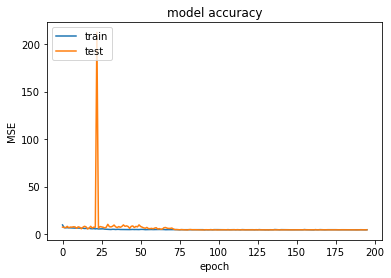

In [16]:
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model accuracy')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [17]:
get_score(model, NN = True)

RMSE: 2.11
RMSE/mean: 0.7


In [71]:
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor, GradientBoostingRegressor, StackingRegressor, VotingRegressor
    
    
    
#попробуем сразу несколько моделей с дефолтными параметрами
estimators = [
        ('rf', RandomForestRegressor()),
        ('grd', GradientBoostingRegressor())]

models = {'AdaBoostRegressor' : AdaBoostRegressor(),
          'BaggingRegressor' : BaggingRegressor(),
          'ExtraTreesRegressor' : ExtraTreesRegressor(), 
          'GradientBoostingRegressor' : GradientBoostingRegressor(),
          'StackingRegressor' : StackingRegressor(estimators = estimators), 
          'VotingRegressor' : VotingRegressor(estimators = estimators)}

#фитим каждую модель на наших данных и выводим принт об удачном фитинге
results = {}
for model in models.values():
    model.fit(X_train, y_train)
    results[model] = get_score(model)
    print(f'{model} is fitted successfully')

RMSE: 2.13
RMSE/mean: 0.7
MAE: 1.78
MAE/mean: 0.59
AdaBoostRegressor() is fitted successfully
RMSE: 2.03
RMSE/mean: 0.67
MAE: 1.55
MAE/mean: 0.51
BaggingRegressor() is fitted successfully
RMSE: 1.94
RMSE/mean: 0.64
MAE: 1.5
MAE/mean: 0.5
ExtraTreesRegressor() is fitted successfully
RMSE: 1.97
RMSE/mean: 0.65
MAE: 1.55
MAE/mean: 0.51
GradientBoostingRegressor() is fitted successfully
RMSE: 1.94
RMSE/mean: 0.64
MAE: 1.52
MAE/mean: 0.5
StackingRegressor(estimators=[('rf', RandomForestRegressor()),
                              ('grd', GradientBoostingRegressor())]) is fitted successfully
RMSE: 1.94
RMSE/mean: 0.64
MAE: 1.53
MAE/mean: 0.5
VotingRegressor(estimators=[('rf', RandomForestRegressor()),
                            ('grd', GradientBoostingRegressor())]) is fitted successfully


In [20]:
import lightgbm as lgm
lgm_train = lgm.Dataset(X_train, label = y_train)
lgm_test = lgm.Dataset(X_test, label = y_test)

param = {'num_leaves': 31, 'objective': 'regression'}
param['metric'] = 'rmse'

lgb_model = lgm.train(param, lgm_train, 100, valid_sets=[lgm_test])

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001895 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12810
[LightGBM] [Info] Number of data points in the train set: 3580, number of used features: 57
[LightGBM] [Info] Start training from score 3.023184
[1]	valid_0's rmse: 2.4265
[2]	valid_0's rmse: 2.35399
[3]	valid_0's rmse: 2.29237
[4]	valid_0's rmse: 2.24459
[5]	valid_0's rmse: 2.20059
[6]	valid_0's rmse: 2.16218
[7]	valid_0's rmse: 2.13595
[8]	valid_0's rmse: 2.11454
[9]	valid_0's rmse: 2.0933
[10]	valid_0's rmse: 2.07667
[11]	valid_0's rmse: 2.06718
[12]	valid_0's rmse: 2.05962
[13]	valid_0's rmse: 2.05427
[14]	valid_0's rmse: 2.04692
[15]	valid_0's rmse: 2.04001
[16]	valid_0's rmse: 2.03072
[17]	valid_0's rmse: 2.02612
[18]	valid_0's rmse: 2.02275
[19]	valid_0's rmse: 2.01936
[20]	valid_0's rmse: 2.01302
[21]	valid_0's rmse: 2.01224
[22]	valid_0's rmse: 2.00744
[23]	valid_0's rmse: 2.00556

In [45]:
get_score(lgb_model)

RMSE: 2.02
RMSE/mean: 0.67
MAE: 1.58
MAE/mean: 0.52


In [26]:
gb = GradientBoostingRegressor(n_estimators=1000)
gb.fit(X_train, y_train)
get_score(gb)

RMSE: 2.0
RMSE/mean: 0.66
